# Estimating SWE

This is an experiment to try calculating SWE based on the phase change. I won't really apply many corrections or filtering to these. 


- Load raw SLCs 
- Get angle (phase) from SLCs 
- Difference the angle between the pairs of SLCs 
- Plot (hope to see fringes!)

I'll actually want to do this with GAMMA, I think. Really just to see for this project, anyways. 

In [2]:
import numpy as np
from pathlib import Path
from datetime import datetime
from time import time
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
import math

# uavsar code
from uavsar_pytools.convert.tiff_conversion import read_annotation


/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/Users/julo9057/anaconda3/envs/snowex_uavsar_coherence/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# working in radar coordinates for now
data_dir = '../data/snowex_lowman/slcs_raw/'

# use just 05208 flight 2021 data for now
in_dir = Path(data_dir)
slcs_05208 = sorted(list(in_dir.glob('*05208_21*.slc')))
anns_05208 = sorted(list(in_dir.glob('*05208_21*.ann')))

In [4]:
d = read_annotation(anns_05208[0])
d = pd.DataFrame(d).T
rows, cols = d.loc['slc_2_2x8 rows', 'value'], d.loc['slc_2_2x8 columns', 'value']
print(rows, cols)
stack = np.zeros((len(slcs_05208), rows, cols), '<c8')
dates = []
for i, (slc, ann) in enumerate(zip(slcs_05208, anns_05208, strict = True)):
    print(slc)
    d = read_annotation(ann)
    d = pd.DataFrame(d).T
    timestamp = d.loc['start time of acquisition', 'value']

    stack[i, :, :] = np.fromfile(slc, '<c8').reshape(rows, cols)
    dates.append(timestamp)

8333 4896
../data/snowex_lowman/slcs_raw/lowman_05208_21009_005_210203_L090VV_01_BU_s2_2x8.slc
../data/snowex_lowman/slcs_raw/lowman_05208_21012_004_210210_L090VV_01_BU_s2_2x8.slc
../data/snowex_lowman/slcs_raw/lowman_05208_21015_009_210303_L090VV_01_BU_s2_2x8.slc
../data/snowex_lowman/slcs_raw/lowman_05208_21017_019_210310_L090VV_01_BU_s2_2x8.slc
../data/snowex_lowman/slcs_raw/lowman_05208_21019_019_210316_L090VV_01_BU_s2_2x8.slc
../data/snowex_lowman/slcs_raw/lowman_05208_21021_007_210322_L090VV_01_BU_s2_2x8.slc


In [5]:
print(len(stack))


6


To calculate phase change, we use np.angle to get the phase from the SLC which represents the phase and amplitude in complex number form. 

Once we have the angle (phase), we subtract phase 2 

In [6]:
print(f"Number of interferograms: {math.comb(len(stack), 2)}")

Number of interferograms: 15


In [6]:
counter = 0
stack_intf = np.zeros((math.comb(len(stack), 2), rows, cols))

# calculate phase change 
for i in range(len(stack)) : 
    for j in range(i, len(stack)) : 
        if (i == j) : 
            continue
        phase1 = np.angle(stack[i])
        phase2 = np.angle(stack[j])

        # print(phase1)
        # print(phase2)

        phase_change = phase2 - phase1

        stack_intf[counter, :, :] = phase_change
        counter += 1


In [12]:
print(stack_intf[0])

[[ 0.          0.         -0.98510242 ... -0.71706629  0.
   0.        ]
 [ 0.          0.         -0.12107062 ...  0.52728319  0.
   0.        ]
 [ 0.          0.         -3.92588878 ... -0.17402089  0.
   0.        ]
 ...
 [ 0.          0.          1.62762296 ... -4.07386017  0.
   0.        ]
 [ 0.          0.          2.67613459 ... -5.82190037  0.
   0.        ]
 [ 0.          0.          1.0567385  ... -1.9307164   0.
   0.        ]]


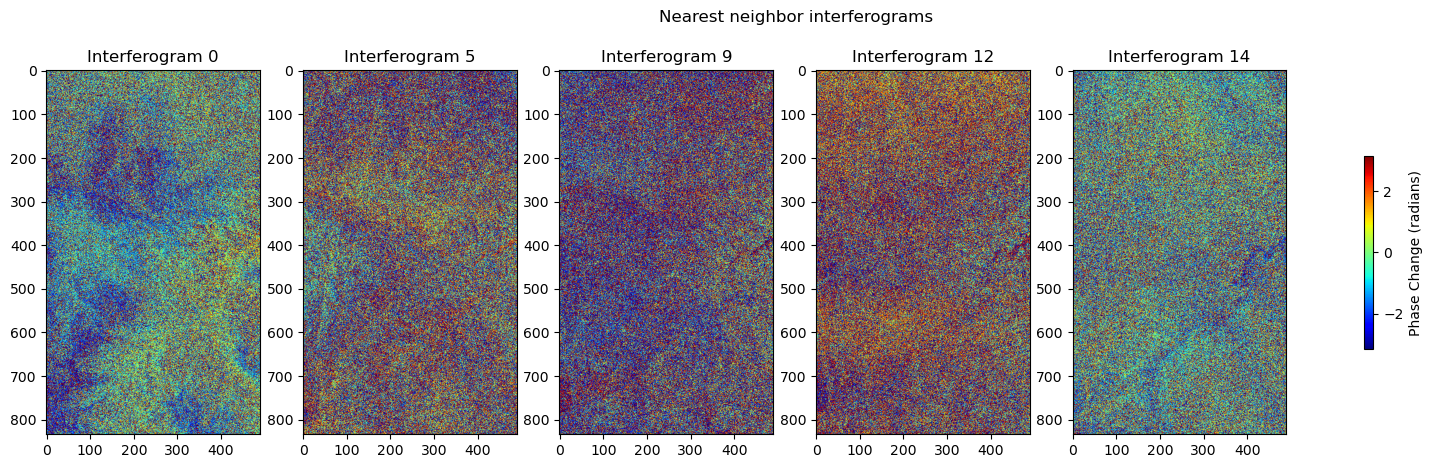

In [ ]:
# downsample nearest neighbors to be able to plot them side-by-side 
indices = [0, 5, 9, 12, 14]

fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))

for idx in indices :
    phase_data = stack_intf[idx, :, :]

    # downsample by factor of 10 for plotting
    phase_data_ds = phase_data[::10, ::10]
    ax = axes[indices.index(idx)]
    im = ax.imshow(phase_data_ds, cmap='jet', vmin=-np.pi, vmax=np.pi)
    ax.set_title(f'Interferogram {idx}')

fig.suptitle('Nearest neighbor interferograms')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Phase Change (radians)')

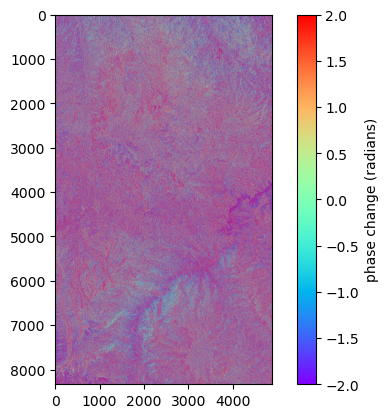

In [ ]:
fig = plt.imshow(stack_intf[14], cmap='rainbow', vmin = -3, vmax = 3)
plt.colorbar(label = 'phase change (radians)')
plt.show()

I don't see any fringes in my first go at plots. The phase difference should in theory be a plot with fringes showing wrapped phase change. 
